# Domača naloga 1 - Uvod v strojno učenje

Najprej bi le rad nekoliko opisal moje predznanje in kako sem si posledično zastavil to domačo nalogo. Sam sem se spoznal s Pythonom že precej časa nazaj, vendar ga nikoli nisem uporabljal za podatkovne potrebe. Večinoma sem ga uporabljal za avtomatizacijo različnih ponovljivih taskov, web-scraping ipd. Medtem ko sem R uporabljal za obdelovanje podatkov in postavljanje modelov, tako pri različnih predmetih kot v službi. Tako da sem se z metodami ki so uporabljene že spoznal, vendar ne v okviru Pythona. Tako da je to pravzaprav zame prvič, da uporabljam paketa scikit-learn in Jupyter.

V nalogi bom najprej opravil kratko analizo podatkov, morebitno imputacijo ter nato še primerjal nekaj metod/modelov, ki smo jih spoznali na predavanjih. Ti so:

* Odločitveno drevo
* Naivni Bayes
* Logistična regresija


## Uvoz in kratek pregled podatkov

Najprej uvozimo pakete


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

Nato preberimo podatke in jih razdelimo na učne in testne podatke. Za tem preglejmo strukturo le na učnih podatkih. (prebrani `test` podatki so le za objavo na kaggle-u. Naši testni podatki za testiranje modelov so `X_test` in `y_test`.)

In [2]:
train_full = pd.read_csv("train.csv")
X_train, X_test, y_train, y_test = train_test_split(train_full.drop(["Survived"],
                                                                    axis = "columns"), 
                                                    train_full.Survived, 
                                                    test_size = 0.3,
                                                    random_state=8)

# za lazje prikazovanje grafov
train = pd.concat([X_train, y_train], axis = 1)

test = pd.read_csv("test.csv")

Test podatke damo na stran, in vso analizo opravljamo le na _train_ podatkih.

In [3]:
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
26991,26991,1,"Zito, David",male,62.0,0,0,24856,240.26,E17098,S,0
95651,95651,3,"Labo, Lucretia",female,29.0,0,0,12966,11.63,NaN,Q,1
11233,11233,1,"Tobler, Kecia",female,44.0,0,0,PC 27547,212.40,C5819,S,1
62183,62183,2,"Krout, Mary",female,23.0,0,1,464492,30.34,NaN,C,1
67510,67510,1,"Woodward, Luis",male,28.0,0,0,41270,19.62,C20965,S,1


In [4]:
train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,70000.000000,70000.00000,67751.000000,70000.000000,70000.000000,69891.000000,70000.000000
mean,49984.981943,2.10520,38.414882,0.399457,0.455943,43.876515,0.428257
std,28872.626814,0.83782,18.328084,0.866678,0.948781,69.170746,0.494830
min,1.000000,1.00000,0.080000,0.000000,0.000000,1.280000,0.000000
25%,25019.750000,1.00000,25.000000,0.000000,0.000000,10.040000,0.000000
50%,49959.500000,2.00000,39.000000,0.000000,0.000000,24.450000,0.000000
75%,75049.500000,3.00000,53.000000,1.000000,1.000000,33.490000,1.000000
max,99998.000000,3.00000,85.000000,8.000000,9.000000,744.660000,1.000000


`describe()` nam vrne le številske spremenljivke pa vendarle vidimo da imamo nekaj manjkajočih vrednosti pri spremenljivki `Age` in `Fare`. Ena od možnosti bi bila da jih odstranimo, da nam ostanejo le zapisi z vsemi vrednostmi, ali pa jih enostavno nadomestimo z mediano ali povprečjem. Poglejmo si še delež manjkajočih vrednosti v spremenljivki.

In [5]:
train.isnull().sum()/len(train)*100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             3.212857
SibSp           0.000000
Parch           0.000000
Ticket          4.654286
Fare            0.155714
Cabin          67.828571
Embarked        0.241429
Survived        0.000000
dtype: float64

Vidimo da poleg omenjenih spremenljivk je najbolj problematična spremenljivka `Cabin` ki ima približno 68% manjkajočih vrednosti, zato je ne bomo uporabili za modeliranje. Pri spremenljivki `Embarked` bomo manjkajoče vrednosti nadomestili naključno v enakem razmerju kot so ostale vrednosti. Pri spremenljivki `Ticket` težko vidim kako bi lahko bila uporabna, zato je ravno tako ne bomo uporabili. `PassengerId` bomo tudi izpustili, saj je le zaporedna številka potnika. Podobno bomo naredili z `Name` saj ne vidim kako bi lahko ime vplivalo na to ali nekdo umre ali ne.

Preden imputiramo, si poglejmo še nekaj slik razdaljenih po spremenljivki `Survived`, ki jo želimo napovedati.

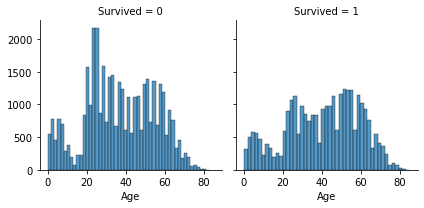

In [6]:
g = sns.FacetGrid(train, col="Survived")
g.map(sns.histplot, "Age")

Hitro vidimo, da je za mlajše osebe bolj umirale kot starejše. Kar je pa ravno obratno pri preživelih, več starejših je preživelo kot mlajših.

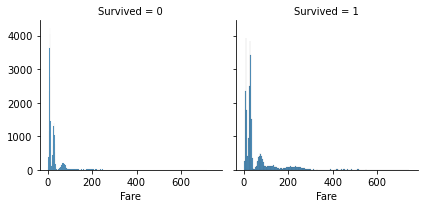

In [7]:
g = sns.FacetGrid(train, col="Survived")
g.map(sns.histplot, "Fare")

Tu ni opaziti nekih večjih razlik, sicer je to lahko posledica le premajhnega grafa. Edina malenkost, ki jo je nekoliko opaziti je pri tistih ki so več plačali za karto (nad $200$) videti kot manjši greben. Poglejmo si še omenjeni spremenljivki v razsevnem diagramu, saj sta edini številski spremenljivki.

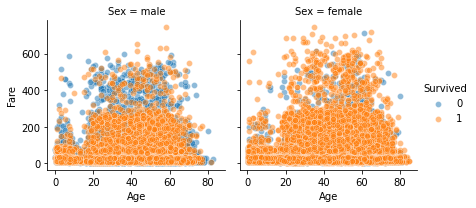

In [8]:
g = sns.FacetGrid(train, col="Sex", hue="Survived")
g.map(sns.scatterplot, "Age", "Fare", alpha=.5)
g.add_legend()

Slika je nekoliko nepregledna, pa vendarle je opaziti več modrih pik (umrlih) pri moškem spolu. Poglejmo si enak prikaz še za spremenljivki `Pclass` ter `Embarked`.


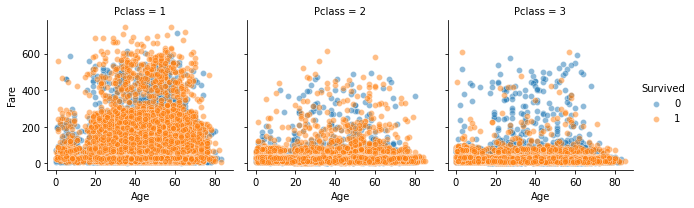

In [9]:
g = sns.FacetGrid(train, col="Pclass", hue="Survived")
g.map(sns.scatterplot, "Age", "Fare", alpha=.5)
g.add_legend()

Podobno kot pri spolu vidimo tudi tukaj, le da je več umrlih pri `Pclass` $=3$. Še `Embarked`.

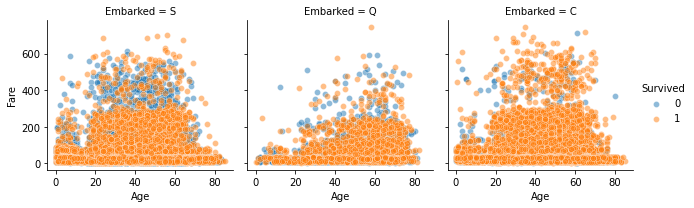

In [10]:
g = sns.FacetGrid(train, col="Embarked", hue="Survived")
g.map(sns.scatterplot, "Age", "Fare", alpha=.5)
g.add_legend()

Zopet podobno kot prej, vidimo nekaj več modrih pik pri `Embarked` $=S$. 

Poglejmo si še v kombinaciji kategoričnimi spremenljivkami, da bodisi potrdimo oz. vidimo kaj novega.

<AxesSubplot:xlabel='Sex', ylabel='Age'>

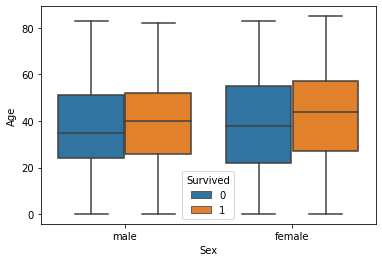

In [11]:
sns.boxplot(x="Sex", y="Age", hue="Survived", data=train)

Na prikazanemu vidimo da je starost umrlih pri obeh spolih nekoliko nižja v primerjavi s preživelimi, kar smo nekako že predvidevali. Poglejmo še za `Fare`.

<AxesSubplot:xlabel='Sex', ylabel='Fare'>

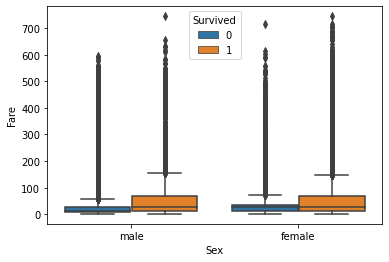

In [12]:
sns.boxplot(x="Sex", y="Fare", hue="Survived", data=train)

Ni videti veliko, poglejmo si raje le povprečne vrednosti.

<AxesSubplot:xlabel='Sex', ylabel='Fare'>

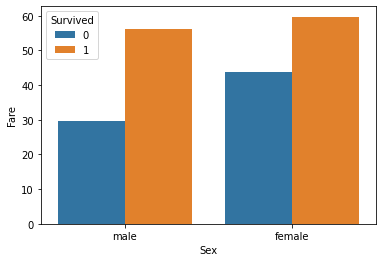

In [13]:
sns.barplot(x="Sex", y="Fare", hue="Survived", ci=None, data=train)

Prej nismo veliko sklepali, vendar je tu lepo videti da tisti ki so umrli, so plačali manj za karto kot tisti ki so preživeli ne glede na spol, kar je najverjetneje posledica tudi v katerem klasu so bili, kjer smo že opazili da tisti ki so bili v $3$, je bila večja verjetnost da so umrli. Poglejmo si to.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

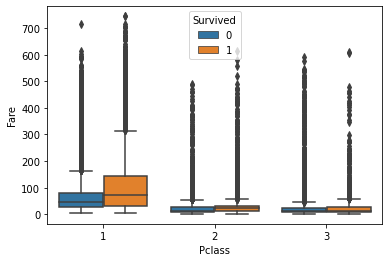

In [14]:
sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=train)

Tu to ni dobro opaziti, pričakoval sem da bo večja razlika. Kar je pa dobro opaziti je pa to, da so umrli v prvem klasu plačali manj za karto. Poglejmo si še `Barplot()`.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

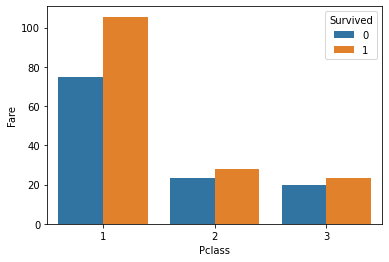

In [15]:
sns.barplot(x="Pclass", y="Fare", hue="Survived", ci=None, data=train)

Tu je še bolje opaziti to da so umrli v prvem klasu plačali manj za karto. Poglejmo si še spremenljivki `SibSp` in `Parch`, ki sta načeloma celoštevilski spremenljivki, vendar jih bomo obravnavali kot kategorične zaradi lažjega prikaza podatkov.

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

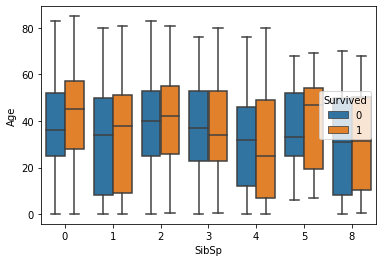

In [16]:
sns.boxplot(x="SibSp", y="Age", hue="Survived", data=train)

Tu pravzaprav ni videti da bi bile kake večje razlike med umrlimi in preživelimi, poglejmo si še `Age` glede na `Parch` .

<AxesSubplot:xlabel='Parch', ylabel='Age'>

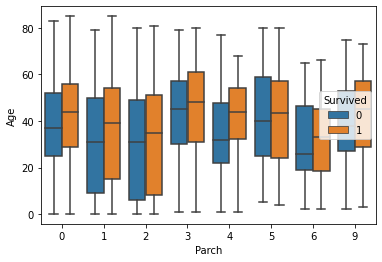

In [17]:
sns.boxplot(x="Parch", y="Age", hue="Survived", data=train)

Tu podobno ni videti nekih razlik, le to da so umrli bili mlajši od preživelih, kar smo pa že opazili. Poglejmo še `Fare` za obe spremenljivki.

<AxesSubplot:xlabel='SibSp', ylabel='Fare'>

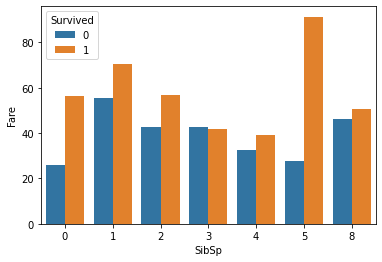

In [18]:
sns.barplot(x="SibSp", y="Fare", hue="Survived", ci=None, data=train)

Tu je opaziti neka večja odstopanja kot je npr. umrli ki so potovali brez ljudi s katerimi so bili v sorodstvenem razmerju, so bili v povprečju za polovico mlajši. Podobno velja za umrle ki so potovali s 5 takšnimi osebami. Tu sumim da je to posledica majhnega števila zapisov. Preverimo.

In [19]:
pd.crosstab(train.Survived, train.SibSp)

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,29381,7818,1419,687,515,69,133
1,21891,6024,1194,457,313,17,82


Točno to vidimo, da imamo najmanj zapisov pri `SibSp`$=5$. Zato lahko to nekoliko ignoriramo. Nadaljujmo s `Parch`.

<AxesSubplot:xlabel='Parch', ylabel='Fare'>

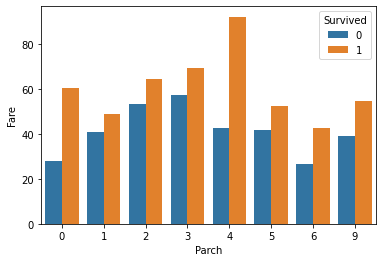

In [20]:
sns.barplot(x="Parch", y="Fare", hue="Survived", ci=None, data=train)

Podobno vidimo kot prej. Pri `Parch`$=0$ je to lahko posledica tega, da to pomeni da so umrle mlajše osebe ki so potovale z varuškami (lahko razberemo iz navodil). Poglejmo podobno kontingenčno tabelo kot prej. vidimo da imamo pri višjih vrednostih `Parch` manj opazovanj.

In [21]:
pd.crosstab(train.Survived, train.Parch)

Parch,0,1,2,3,4,5,6,9
Survived,,,,,,,,
0,30489,3780,4862,355,226,100,112,98
1,20905,5360,3039,352,83,126,28,85


Torej moje trenuto pričakovanje je, da so bolj pogosto umirali:

* Moški (`Sex`$=male$)
* Tisti ki so potovali v tretji klasi (`Pclass`$=3$)
* Se je vkrcal v Southamptonu (`Embarked`$=S$)
* Mlajše osebe (npr. `Age`$<18$)

Zagotovo sem izpustil kak pomemben pogled, vendar se mi zdi da je za potrebe te naloge bolj pomemben naslednji del.

## Manjkajoče vrednosti in ureditev podatkov

Za `Age` in `Fare` sem se odločil da jima bom nadomestil manjkajoče vrednosti z mediano, s tem da bom `Fare` nadomestil glede na povprečje po `Pclass`, saj smo videli na enem grafu prej, da boljši kot je `Pclass` višja je bila vrednost `Fare`.

Vse manjkajoče vrednosti zamenjamo tudi na `test` vzorcu (izračunane na `train`).

In [22]:
# age fill NA simple median
age_med = X_train["Age"].median()
print("Mediana starosti: ",age_med)
X_train["Age"] = X_train["Age"].fillna(age_med)
X_test["Age"] = X_test["Age"].fillna(age_med)

# fare fill NA by Pclass median
print("Mediane Fare po Pclass:")
fare_pc_med_dict = X_train[["Fare", "Pclass"]].dropna().groupby("Pclass").median().to_dict()
print(fare_pc_med_dict)
X_train["Fare"] = X_train["Fare"].fillna(X_train["Pclass"].map(fare_pc_med_dict["Fare"]))
X_test["Fare"] = X_test["Fare"].fillna(X_test["Pclass"].map(fare_pc_med_dict["Fare"]))

# Embarked fill NA randomlly with equal ratio as non-NA

mask1 = X_train["Embarked"].isnull()
samples = random.choices(X_train["Embarked"][~mask1].unique(),
                         weights = list(X_train["Embarked"].value_counts()/len(X_train[~mask1])), 
                         k = mask1.sum() ,)
X_train["Embarked"][mask1] = samples

mask2 = X_test["Embarked"].isnull()
samples = random.choices(X_train["Embarked"][~mask1].unique(),
                         weights = list(X_train["Embarked"].value_counts()/len(X_train[~mask1])), 
                         k = mask2.sum() ,)
X_test["Embarked"][mask2] = samples

# remove variables not used for modelling
X_train = X_train.drop(["Ticket", "Cabin", "PassengerId", "Name"], axis="columns")
X_test = X_test.drop(["Ticket", "Cabin", "PassengerId", "Name"], axis="columns")

Mediana starosti:  39.0
Mediane Fare po Pclass:
{'Fare': {1: 63.89, 2: 22.73, 3: 10.93}}


Zvezne podatke bomo diskretizirali, kljub temu da to ne bi bilo potrebno za nekater algoritme, vendar bomo na enakih podatkih lažje primerjali različne modele. Podatke ki so že kategorični, bomo spremenili le v številski zapis, zato da bodo na nek način normalizirani.

In [576]:
# diskretiziramo starost zaradi naivnega bayesa. Skupine so 5 letne.
# podobno za Fare le da so skupine po 20$

age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
            55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

age_labels = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,
              11, 12, 13, 14, 15, 16, 17, 18, 19]

fare_bins = np.linspace(0, 1000, num=51)
fare_labels = np.linspace(0, 49, 50)

X_train["Age"] = pd.cut(x = X_train["Age"],
       bins = age_bins,
       labels = age_labels)
X_test["Age"] = pd.cut(x = X_test["Age"],
       bins = age_bins,
       labels = age_labels)

X_train["Fare"] = pd.cut(x = X_train["Fare"],
       bins = fare_bins,
       labels = fare_labels)
X_test["Fare"] = pd.cut(x = X_test["Fare"],
       bins = fare_bins,
       labels = fare_labels)



In [577]:
lab_enc = LabelEncoder()
X_train["Sex"] = lab_enc.fit_transform(X_train.Sex)
X_train["Embarked"] = lab_enc.fit_transform(X_train.Embarked)
X_test["Sex"] = lab_enc.fit_transform(X_test.Sex)
X_test["Embarked"] = lab_enc.fit_transform(X_test.Embarked)

## Modeli

### Odločitveno drevo

0.7652666666666667

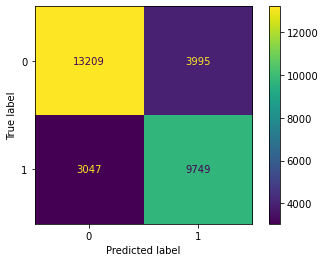

In [578]:
dtc = DecisionTreeClassifier(random_state=8, # zgledajo OK nastavitve
                             max_depth=4,
                             min_samples_leaf=2)
dtc.fit(X_train, y_train)

plot_confusion_matrix(dtc, X_test, y_test)

dtc.score(X_test, y_test)

In [579]:
print(classification_report(dtc.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79     16256
           1       0.76      0.71      0.73     13744

    accuracy                           0.77     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.77      0.77      0.76     30000



### Logistična regresija

0.7649666666666667

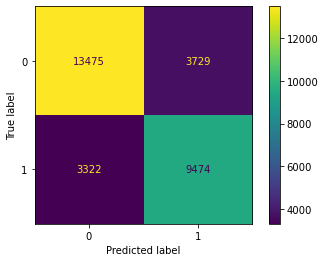

In [580]:
lr = LogisticRegression(random_state = 8)
lr.fit(X_train, y_train)

plot_confusion_matrix(lr, X_test, y_test)

lr.score(X_test, y_test)

In [581]:
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     16797
           1       0.74      0.72      0.73     13203

    accuracy                           0.76     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.76      0.76      0.76     30000



### Naivni Bayes

0.7412

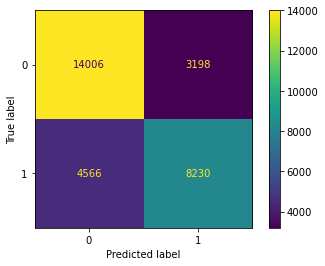

In [582]:
nb = GaussianNB()
nb.fit(X_train, y_train)

plot_confusion_matrix(nb, X_test, y_test)

nb.score(X_test, y_test)

In [583]:
print(classification_report(nb.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     18572
           1       0.64      0.72      0.68     11428

    accuracy                           0.74     30000
   macro avg       0.73      0.74      0.73     30000
weighted avg       0.75      0.74      0.74     30000



## Zaključek

Vidimo, da so si vsi trije modeli zelo blizu po natančnosti. Najbolje se je sicer odrezalo odločitveno drevo, vendar je to lahko le posledica naključnosti. Da bi se to preverilo bi lahko nalogo razširili tako, da se doda prečno preverjanje, za kar mi je nekoliko zmanjkalo časa. Zagotovo bi lahko bila tudi imputacija boljša, kot tudi sama prvotna analiza ter najverjetneje bi natančnosti največ doprineslo to, da bi ustvarili nove spremenljivke. Najboljši model, bi se nato uporabil na testnih podatkih za Kaggle, kjer bi lahko videli kako dober je dejansko bil naš model.

Moj cilj za to nalogo, kot omenjeno, je bil da se spoznam z orodjem Jupyter notebooks ter s SciKit-Learn paketom, kar se mi zdi da je bilo uspešno. Pomembno mi je bilo, da sem pravilno nadomestil podatke tako v učnih kot testnih podatkih, ter da ni prihajalo do morebitnega uhajanja informacij.